In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from statistics import linear_regression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

Create a function to strip out all the relevant model simulations for a difference array

In [2]:
def calculate_experiment_diff(all_runs, generation, experiment_name, control_experiment='piControl'):
    # Filter runs for the specific experiment and control experiment
    experiment_runs = all_runs.loc[(all_runs['experiment'] == experiment_name) & (all_runs['generation'] == generation)]
    experiment_runs.set_index('model', inplace=True)
    
    control_runs = all_runs.loc[(all_runs['experiment'] == control_experiment) & (all_runs['generation'] == generation)]
    control_runs.set_index('model', inplace=True)
    
    # Filter control runs to only include models present in the experiment runs
    experiment_control_runs = control_runs[control_runs.index.isin(experiment_runs.index)]
    
    # Drop the 'experiment' and 'years' columns
    experiment_control_runs.drop(['generation','experiment', 'years'], axis=1, inplace=True)
    experiment_runs.drop(['generation','experiment', 'years'], axis=1, inplace=True)
    
    # Create a difference DataFrame
    diff = experiment_runs - experiment_control_runs
    diff['experiment'] = experiment_name
    diff['generation'] = generation
    diff['run'] = list(range(0, np.size(experiment_runs.index)))
    diff.reset_index(inplace=True)
    diff.set_index('run', inplace=True)
    
    return diff

### Load in the tidy numbers file from summary_data

In [3]:
all_runs = pd.read_csv("summary_data/tidy_numbers.csv")
# Jump through some hopes to remove suspect data...
numerical=all_runs.iloc[:,3:]
numerical.mask(abs(numerical) > 1e6, np.nan,inplace=True)
#numerical.mask(abs(numerical) < 1e-6, np.nan,inplace=True)
all_runs.iloc[:,3:]=numerical
all_runs[10:20]

,generation,model,experiment,years,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,...,NEB rain djf stddev,r(atl3.nino34),r(atl3.amo),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev
10,PMIP3,CNRM-CM5,midHolocene-cal-adj,200,13.44340,27.1278,0.404581,0.738694,27.1278,0.406142,...,0.474636,0.258286,-0.073615,2.94118,3.92157,4.76190,0.209912,0.593376,0.333129,1.079960
11,PMIP3,CNRM-CM5,piControl,850,13.20040,27.2500,0.369616,0.810513,27.2500,0.370870,...,0.499597,0.197199,-0.091163,3.63248,2.81457,6.85484,0.206020,0.592720,0.288996,1.194510
12,PMIP3,COSMOS-ASO,lgm-cal-adj,600,6.97033,23.3069,0.772255,1.784770,23.3069,0.772358,...,0.477931,0.416506,0.009899,4.51128,4.95868,6.25000,0.532273,0.619322,0.550877,1.530570
13,PMIP3,COSMOS-ASO,piControl,400,12.44070,27.3068,0.562300,1.780830,27.3068,0.570502,...,0.478433,0.395212,-0.104874,3.60360,3.60360,7.01754,0.359882,0.881988,0.525629,1.492910
14,PMIP3,CSIRO-Mk3-6-0,abrupt4xCO2,150,18.44520,28.0317,0.347694,0.958433,29.2015,0.347693,...,0.267330,0.080685,0.018165,3.10000,6.20000,1.63158,0.234013,0.253396,0.333338,0.080647
15,PMIP3,CSIRO-Mk3-6-0,midHolocene-cal-adj,100,12.81170,23.6707,0.446059,0.805980,23.6707,0.450611,...,0.305654,-0.159986,-0.056988,1.75439,3.84615,7.69231,0.281829,0.245367,0.409170,0.125021
16,PMIP3,CSIRO-Mk3-6-0,piControl,500,12.73370,23.9278,0.414529,0.680119,23.9278,0.419222,...,0.377981,-0.023831,0.018407,2.45098,7.81250,5.20833,0.285929,0.241426,0.436068,0.151375
17,PMIP3,CSIRO-Mk3L-1-2,midHolocene-cal-adj,500,14.09290,26.6729,0.264040,0.441060,26.6729,0.264435,...,0.487207,0.145686,-0.099377,7.81250,7.81250,5.20833,0.213068,0.321289,0.360917,0.401921
18,PMIP3,CSIRO-Mk3L-1-2,piControl,1000,14.04120,26.8395,0.283316,0.534729,26.8395,0.283810,...,0.715183,0.226107,-0.192573,7.93651,7.51880,5.37634,0.227940,0.307086,0.375083,0.358038
19,PMIP3,FGOALS-g2,abrupt4xCO2,258,18.82780,30.9886,0.228013,0.541508,31.6808,0.228014,...,0.295914,0.409993,0.102987,4.42857,3.44444,5.16667,0.168199,0.458985,0.260991,1.071820


Select the lgm runs (we'll take the calendar adjusted ones).

Then duplicate this and populate with the piControl equivalent numbers

In [4]:
lgm4_diff=calculate_experiment_diff(all_runs, "PMIP4", "lgm-cal-adj", control_experiment='piControl')
lgm3_diff=calculate_experiment_diff(all_runs, "PMIP3", "lgm-cal-adj", control_experiment='piControl')
lgm_diff=pd.concat([lgm4_diff,lgm3_diff])
lgm_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AtlNino AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.amo),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,experiment,generation
run,,,,,,,,,,,,,,,,,,,,,
0,AWI-ESM-1-1-LR,-3.71394,-1.5402,0.045615,0.146279,-1.5402,0.045074,0.06988,-0.229227,0.049754,...,-0.113669,0.20270,-1.31362,0.23810,0.023975,0.005319,0.097718,0.268470,lgm-cal-adj,PMIP4
1,INM-CM4-8,-3.72303,-1.2889,0.145785,0.076214,-1.2889,0.140282,-0.68872,-3.210517,0.317259,...,0.253801,-4.59478,0.52968,1.98263,0.084050,0.577534,0.175200,1.975299,lgm-cal-adj,PMIP4
2,MIROC-ES2L,-4.04850,-2.5732,0.149163,-0.156850,-2.5732,0.149556,0.57702,-0.019281,0.074201,...,NaN,-1.00000,-0.50654,-2.94444,0.174272,0.136910,0.312965,0.679370,lgm-cal-adj,PMIP4
3,UofT-CCSM-4,-5.27000,-2.4261,0.091440,-0.137060,-2.4261,0.091297,0.58700,0.522140,0.015283,...,NaN,-0.61919,-0.89955,0.00000,0.074780,0.089172,0.215456,0.482600,lgm-cal-adj,PMIP4
0,CCSM4,-4.91608,-2.1456,0.052002,-0.177133,-2.1456,0.051852,0.04609,-0.118035,0.020961,...,0.045641,0.57162,0.11836,-1.29429,0.023364,0.063091,0.101323,0.350140,lgm-cal-adj,PMIP3
1,CNRM-CM5,-2.63480,-1.4687,-0.003960,0.020978,-1.4687,-0.004890,0.40581,0.050328,-0.013339,...,-0.004531,-2.41297,0.12661,-1.29928,-0.013341,-0.049764,-0.008784,-0.157190,lgm-cal-adj,PMIP3
2,COSMOS-ASO,-5.47037,-3.9999,0.209955,0.003940,-3.9999,0.201856,0.22525,0.260643,-0.036029,...,0.114773,0.90768,1.35508,-0.76754,0.172391,-0.262666,0.025248,0.037660,lgm-cal-adj,PMIP3
3,FGOALS-g2,-4.58484,-2.8489,0.043447,-0.348958,-2.8489,0.042782,0.45131,-0.128027,0.078076,...,0.042913,1.42045,-0.34078,-1.76086,0.043412,0.034186,0.081789,0.195030,lgm-cal-adj,PMIP3
4,GISS-E2-R,-4.80725,-1.8912,0.027831,-0.162594,-1.8912,0.027849,0.03201,-0.626854,0.074722,...,0.102716,3.93291,-1.63174,-1.93015,0.019337,0.098620,0.051354,0.353490,lgm-cal-adj,PMIP3


In [5]:
lig127k_diff=calculate_experiment_diff(all_runs, "PMIP4", "lig127k-cal-adj", control_experiment='piControl')
lig127k_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AtlNino AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.amo),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,experiment,generation
run,,,,,,,,,,,,,,,,,,,,,
0,ACCESS-ESM1-5,0.4740,272.1327,-0.115760,-0.114513,272.1327,-0.114982,-1.66067,0.917830,-0.011128,...,NaN,-5.14286,0.89184,0.63492,-0.088097,-0.442552,-0.216145,-1.282359,lig127k-cal-adj,PMIP4
1,AWI-ESM-1-1-LR,-0.0981,-0.7774,-0.025851,-0.147396,-0.7774,-0.026393,-1.87723,0.452882,-0.041555,...,0.089122,0.27778,1.48810,3.80953,-0.007716,-0.044848,-0.038624,-0.348710,lig127k-cal-adj,PMIP4
2,CESM2,0.0534,-0.3136,-0.026407,-0.227121,-0.3136,-0.026035,-1.70759,0.048310,-0.018903,...,0.046349,1.66299,1.95972,1.97681,0.000167,-0.178651,-0.061881,-0.611060,lig127k-cal-adj,PMIP4
3,CNRM-CM6-1,0.4924,0.0366,-0.024749,-0.195641,0.0366,-0.024334,-2.15172,0.156544,-0.024103,...,-0.046924,3.05644,-0.58279,-0.66082,-0.015631,-0.130875,-0.066429,-0.771550,lig127k-cal-adj,PMIP4
4,FGOALS-f3-L,-0.2616,-0.7187,-0.060795,-0.270160,-0.7187,-0.061246,-1.25381,0.302060,-0.082742,...,-0.095079,0.54773,0.72384,0.89555,-0.023382,-0.267709,-0.075353,-0.950410,lig127k-cal-adj,PMIP4
5,FGOALS-g3,0.4364,-0.5635,0.013314,-0.275393,-0.5562,0.012970,0.84165,0.297784,-0.047087,...,-0.021427,-0.56427,-0.56427,-4.33136,-0.021603,-0.570731,-0.159806,-1.543930,lig127k-cal-adj,PMIP4
6,GISS-E2-1-G,0.0188,-0.3218,-0.001263,0.003790,-0.3218,-0.001311,-1.26759,0.273985,-0.017904,...,-0.011157,-0.61610,-0.61610,-0.31980,0.000755,-0.276773,0.008799,-0.954670,lig127k-cal-adj,PMIP4
7,HadGEM3-GC31-LL,0.6255,-0.0910,-0.092976,-0.281339,-0.0910,-0.093126,-1.53251,1.017152,-0.152201,...,NaN,-2.32975,2.07208,-1.78197,-0.063614,-0.411658,-0.221479,-1.735541,lig127k-cal-adj,PMIP4
8,INM-CM4-8,-0.0185,-0.2458,-0.013364,0.046921,-0.2458,-0.009156,-0.36360,0.267533,0.014061,...,-0.078864,-1.79366,-1.59617,1.98263,-0.003396,0.138384,0.010754,0.062776,lig127k-cal-adj,PMIP4


In [6]:
midHolocene4_diff=calculate_experiment_diff(all_runs, "PMIP4", "midHolocene-cal-adj", control_experiment='piControl')
midHolocene3_diff=calculate_experiment_diff(all_runs, "PMIP3", "midHolocene-cal-adj", control_experiment='piControl')
midHolocene_diff=pd.concat([midHolocene4_diff,midHolocene3_diff])

In [7]:
abrupt4xCO24_diff=calculate_experiment_diff(all_runs, "PMIP4", "abrupt4xCO2", control_experiment='piControl')
abrupt4xCO23_diff=calculate_experiment_diff(all_runs, "PMIP3", "abrupt4xCO2", control_experiment='piControl')
abrupt4xCO2_diff=pd.concat([abrupt4xCO24_diff,abrupt4xCO23_diff])

In [8]:
midPliocene_diff=calculate_experiment_diff(all_runs, "PMIP4", "midPliocene-eoi400", control_experiment='piControl')
midPliocene_diff

,model,GMTemp,ATL3 mean,ATL3 stddev,Nino34 stddev,AtlNino mean,AtlNino stddev,AtlNino AnnCycAmp,AMM mean,AMM stddev,...,r(atl3.amo),ATL3 Period,ENSO Period,AMM Period,ATL3-sst-interann-stdev,ATL3-pr-interann-stdev,ATL3-sst-interjja-stdev,ATL3-pr-interjja-stdev,experiment,generation
run,,,,,,,,,,,,,,,,,,,,,
0,CESM2,4.9495,3.7814,0.027295,0.045710,3.7814,0.080397,0.02713,-0.262000,-0.006603,...,-0.311281,0.04970,-0.12774,3.51967,0.033475,0.130459,0.045068,0.451628,midPliocene-eoi400,PMIP4
1,EC-Earth3-LR,4.8483,3.0072,-0.119469,-0.330729,3.0072,-0.118955,-0.68993,0.303007,-0.017350,...,-0.102393,0.04374,4.55169,3.59027,-0.058580,-0.063367,-0.246324,-0.189470,midPliocene-eoi400,PMIP4
2,GISS-E2-1-G,2.1005,0.8174,0.002945,0.025390,0.8174,0.003913,0.49958,0.096270,0.017700,...,0.004862,0.44210,0.44210,0.02803,0.011735,-0.181787,-0.015496,-0.618100,midPliocene-eoi400,PMIP4
3,HadGEM3-GC31-LL,5.1708,3.6976,-0.104310,-0.220912,3.6976,-0.103401,0.12031,0.382978,-0.094991,...,-0.095371,-0.79366,1.66667,-0.55556,-0.053272,0.116040,-0.173637,-1.066720,midPliocene-eoi400,PMIP4
4,IPSL-CM6A-LR,3.2650,1.9066,-0.038457,0.024732,1.9066,-0.038487,0.04036,0.351457,-0.029249,...,NaN,-1.16971,0.25679,-2.45211,-0.029063,0.013717,-0.096269,-0.371895,midPliocene-eoi400,PMIP4
5,NorESM1-F,1.7280,1.0939,-0.002019,-0.182541,1.0939,-0.001929,0.04088,0.096867,-0.010939,...,NaN,2.26481,1.18256,2.52936,-0.003727,0.075700,0.017585,0.135360,midPliocene-eoi400,PMIP4
6,UofT-CCSM-4,4.1854,2.3427,-0.004327,-0.253232,2.3427,-0.002041,0.22817,0.227509,-0.040739,...,NaN,-0.88235,0.41407,0.00000,0.016820,0.066127,0.046724,0.126690,midPliocene-eoi400,PMIP4


In [9]:
all_diffs=pd.concat([lgm_diff,midHolocene_diff,lig127k_diff,abrupt4xCO2_diff,midPliocene_diff])
not_abrup4xCO2_diffs=pd.concat([lgm_diff,midHolocene_diff,lig127k_diff,midPliocene_diff])
orb_diffs=pd.concat([midHolocene_diff,lig127k_diff])
pmip4_diffs=pd.concat([lgm4_diff,midHolocene4_diff,abrupt4xCO24_diff,lig127k_diff,midPliocene_diff])

In [10]:
# Add some colors to allow for convenient plotting...
all_diffs['color'] = all_diffs['experiment']
all_diffs['color'] = all_diffs['color'].map({'lgm-cal-adj':'tab:blue',
                             'midHolocene-cal-adj':'tab:olive',
                             'lig127k-cal-adj':'tab:green',
                             'abrupt4xCO2':'tab:red',
                             'midPliocene-eoi400':'tab:pink'},
                             na_action=None)
all_diffs['marker'] = all_diffs['generation']
all_diffs['marker'] = all_diffs['generation'].map({'PMIP4':'o',
                             'PMIP3':'.'},na_action=None)

pmip4_diffs['color'] = pmip4_diffs['experiment']
pmip4_diffs['color'] = pmip4_diffs['color'].map({'lgm-cal-adj':'tab:blue',
                             'midHolocene-cal-adj':'tab:olive',
                             'lig127k-cal-adj':'tab:green',
                             'abrupt4xCO2':'tab:red',
                             'midPliocene-eoi400':'tab:pink'},
                             na_action=None)


<Figure size 640x480 with 0 Axes>

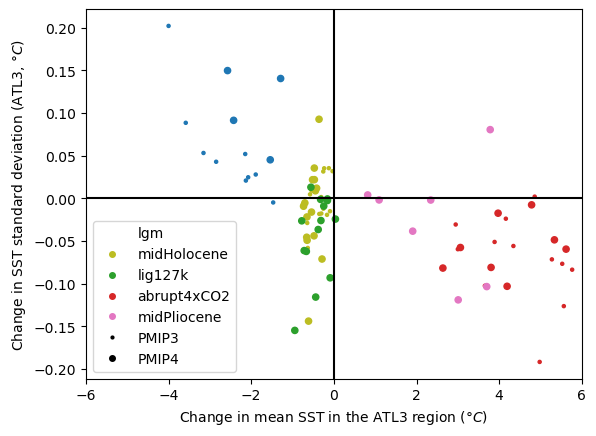

In [26]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AtlNino mean',y='AtlNino stddev',c='color',marker=".").get_figure()
ax=fig.gca()
pmip4_diffs.plot.scatter(x='AtlNino mean',y='AtlNino stddev',c='color',marker='o',ax=ax)
plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.xlim(-6, 6)
plt.xlabel('Change in mean SST in the ATL3 region ($\degree C$)')
plt.ylabel('Change in SST standard deviation (ATL3, $\degree C$)')
# Create custom legend handles
legend1 = mlines.Line2D([], [], color='tab:blue',,marker='o',linestyle='None', markersize=4,label='lgm')
legend2 = mlines.Line2D([], [], color='tab:olive',marker='o', linestyle='None', markersize=4,label='midHolocene')
legend3 = mlines.Line2D([], [], color='tab:green',marker='o', linestyle='None', markersize=4,label='lig127k')
legend4 = mlines.Line2D([], [], color='tab:red',marker='o', linestyle='None', markersize=4,label='abrupt4xCO2')
legend5 = mlines.Line2D([], [], color='tab:pink',marker='o', linestyle='None', markersize=4,label='midPliocene')
legend6 = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=4, label='PMIP3')
legend7 = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=4, label='PMIP4')
ax.legend(handles=[legend1, legend2, legend3,legend4,legend5,legend6,legend7])
fig.savefig('plots/AtlNino_w_mean.png')

In [ ]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AMM AnnCycAmp',y='AMM stddev',c='color',marker='marker').get_figure()
pmip4_diffs.plot.scatter(x='AMM AnnCycAmp',y='AMM stddev',c='color',marker='o',ax=fig.gca())
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/AMM_w_AnnCycAmp.png')

In [ ]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AMM mean',y='AMM stddev',c='color',marker='marker').get_figure()
pmip4_diffs.plot.scatter(x='AMM mean',y='AMM stddev',c='color',marker='o',ax=fig.gca())
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/AMM_w_mean.png')

In [ ]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='AtlNino stddev',y='NEB rain jja stddev',c='color',marker='marker').get_figure()
pmip4_diffs.plot.scatter(x='AtlNino stddev',y='NEB rain jja stddev',c='color',marker='o',ax=fig.gca())
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/NEB-DJF_w_AtlNino_stddev.png')

In [ ]:
fig = plt.figure()
fig=all_diffs.plot.scatter(x='ATL3-sst-interjja-stdev',y='ATL3-pr-interjja-stdev',c='color',marker='marker').get_figure()
pmip4_diffs.plot.scatter(x='ATL3-sst-interjja-stdev',y='ATL3-pr-interjja-stdev,c='color',marker='o',ax=fig.gca())
plt.axhline(0,color='black')
plt.axvline(0,color='black')
fig.savefig('plots/Rainfall_vs_SST_variability_changes.png')